In [17]:
import os
from pathlib import Path
import random

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import load_model

from sklearn.metrics import accuracy_score, classification_report


In [18]:
# Detect project root (if notebook is inside "notebooks", go one level up)
CWD = Path().resolve()
if CWD.name == "notebooks":
    PROJECT_ROOT = CWD.parent
else:
    PROJECT_ROOT = CWD

print("Current working dir:", CWD)
print("Assumed project root:", PROJECT_ROOT)

RAW_CLASS_DIR = PROJECT_ROOT / "data" / "classification_dataset"
MODELS_CLASS_DIR = PROJECT_ROOT / "models" / "classification"

print("RAW_CLASS_DIR:", RAW_CLASS_DIR, "exists:", RAW_CLASS_DIR.exists())
print("MODELS_CLASS_DIR:", MODELS_CLASS_DIR, "exists:", MODELS_CLASS_DIR.exists())

if not RAW_CLASS_DIR.exists():
    raise FileNotFoundError("❌ data/classification_dataset not found. Check your folder structure.")

# Check basic structure
for split in ["train", "valid", "test"]:
    for cls in ["bird", "drone"]:
        p = RAW_CLASS_DIR / split / cls
        print(p, "exists:", p.exists())


Current working dir: F:\Aerial_Object_Classification_Detection\notebooks
Assumed project root: F:\Aerial_Object_Classification_Detection
RAW_CLASS_DIR: F:\Aerial_Object_Classification_Detection\data\classification_dataset exists: True
MODELS_CLASS_DIR: F:\Aerial_Object_Classification_Detection\models\classification exists: True
F:\Aerial_Object_Classification_Detection\data\classification_dataset\train\bird exists: True
F:\Aerial_Object_Classification_Detection\data\classification_dataset\train\drone exists: True
F:\Aerial_Object_Classification_Detection\data\classification_dataset\valid\bird exists: True
F:\Aerial_Object_Classification_Detection\data\classification_dataset\valid\drone exists: True
F:\Aerial_Object_Classification_Detection\data\classification_dataset\test\bird exists: True
F:\Aerial_Object_Classification_Detection\data\classification_dataset\test\drone exists: True


In [19]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE

train_dir = RAW_CLASS_DIR / "train"
val_dir   = RAW_CLASS_DIR / "valid"
test_dir  = RAW_CLASS_DIR / "test"

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)

print("\nClass names:", class_names)
print("num_classes:", num_classes)

# Prefetch (no cache → avoid RAM issues)
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

idx_to_name = {i: n for i, n in enumerate(class_names)}
print("idx_to_name:", idx_to_name)


Found 2662 files belonging to 2 classes.
Found 442 files belonging to 2 classes.
Found 215 files belonging to 2 classes.

Class names: ['bird', 'drone']
num_classes: 2
idx_to_name: {0: 'bird', 1: 'drone'}


In [20]:
model_path = MODELS_CLASS_DIR / "transfer_resnet50_best.h5"
print("Looking for model at:", model_path)

if not model_path.exists():
    raise FileNotFoundError(f"❌ transfer_resnet50_best.h5 not found at {model_path}")

model = load_model(model_path)
model_name = "ResNet50_best"
preprocess_mode = "minus1_1"  # images must be scaled to [-1, 1]

print("✅ Loaded model:", model_name)
model.summary()


Looking for model at: F:\Aerial_Object_Classification_Detection\models\classification\transfer_resnet50_best.h5


✅ Loaded model: ResNet50_best


Model: "resnet50_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,772 (91.98 MB)

 Trainable params: 525,058 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 2 (12.00 B)

In [21]:
IMAGE_SIZE = (224, 224)

def preprocess_image_for_model(img: Image.Image, preprocess_mode: str):
    """
    img: PIL Image
    preprocess_mode: we use 'minus1_1' for ResNet50 here.
    Returns: array of shape (1, 224, 224, 3)
    """
    img = img.convert("RGB")
    img = img.resize(IMAGE_SIZE)
    arr = np.array(img, dtype=np.float32)  # 0-255

    if preprocess_mode == "minus1_1":
        arr = (arr / 255.0) * 2.0 - 1.0   # [0,255] -> [0,1] -> [-1,1]
    else:
        raise ValueError(f"Unsupported preprocess_mode for this notebook: {preprocess_mode}")

    arr = np.expand_dims(arr, axis=0)
    return arr

def predict_image_pil(img: Image.Image, model, preprocess_mode: str):
    """
    Full prediction pipeline for a PIL image.
    Returns:
      predicted_label_name,
      predicted_label_index,
      confidence (float, 0-1),
      probs (full softmax array)
    """
    input_arr = preprocess_image_for_model(img, preprocess_mode)
    probs = model.predict(input_arr, verbose=0)[0]  # shape (num_classes,)

    pred_idx = int(np.argmax(probs))
    pred_label = idx_to_name.get(pred_idx, str(pred_idx))
    confidence = float(probs[pred_idx])

    return pred_label, pred_idx, confidence, probs



Image: F:\Aerial_Object_Classification_Detection\notebooks\data\processed\test\drone\41WwyhHWLbL.jpg_BO30,255,255,255_UF900,850_SR1910,1000,0,C_QL100_.jpg
Predicted: drone  (confidence: 0.9282)
Class probabilities:
  0 (bird): 0.0718
  1 (drone): 0.9282


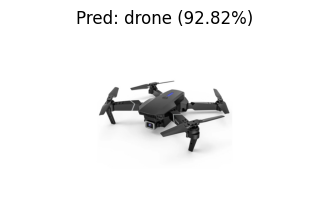

In [25]:
def predict_image_from_path(image_path, model, preprocess_mode: str):
    """
    Given an image file path, open & predict Bird/Drone with confidence.
    """
    image_path = Path(image_path)
    if not image_path.exists():
        print("❌ Image path does not exist:", image_path)
        return None
    
    img = Image.open(image_path)
    pred_label, pred_idx, conf, probs = predict_image_pil(img, model, preprocess_mode)

    print(f"\nImage: {image_path}")
    print(f"Predicted: {pred_label}  (confidence: {conf:.4f})")
    print("Class probabilities:")
    for idx, p in enumerate(probs):
        name = idx_to_name.get(idx, str(idx))
        print(f"  {idx} ({name}): {p:.4f}")

    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Pred: {pred_label} ({conf:.2%})")
    plt.show()

    return pred_label, conf, probs

# 👉 Change this to a REAL image path on your system if you want to test
custom_img_path =(r"F:\Aerial_Object_Classification_Detection\notebooks\data\processed\test\drone\41WwyhHWLbL.jpg_BO30,255,255,255_UF900,850_SR1910,1000,0,C_QL100_.jpg")

if Path(custom_img_path).exists():
    predict_image_from_path(custom_img_path, model, preprocess_mode)
else:
    print("⚠️ Custom image path does not exist:", custom_img_path)
    print("Update 'custom_img_path' to a valid image file if you want to test.")


In [28]:
def load_best_available_model(models_dir: Path):
    """
    Chooses the best available model file.
    Returns:
      model: loaded Keras model
      model_name: human-readable name
      preprocess_mode:
         "raw_0_255"  -> model expects [0,255] uint8/float (has internal Rescaling)
         "0_1"        -> model expects [0,1]
         "minus1_1"   -> model expects [-1,1]
    """
    candidates = [
        # New folder-based EfficientNet fine-tune (recommended)
        ("transfer_efficientnetb0_finetuned_from_folders.h5", "EfficientNetB0_finetuned_folders", "raw_0_255"),
        ("transfer_efficientnetb0_from_folders.h5",           "EfficientNetB0_from_folders",      "raw_0_255"),

        # Older npz-based models (if you have them)
        ("transfer_efficientnetb0_finetuned_best.h5",         "EfficientNetB0_finetuned_npz",     "minus1_1"),
        ("transfer_efficientnetb0_best.h5",                    "EfficientNetB0_npz",               "minus1_1"),
        ("transfer_resnet50_best.h5",                          "ResNet50",                          "minus1_1"),
        ("transfer_mobilenetv2_best.h5",                       "MobileNetV2",                       "minus1_1"),
        ("custom_cnn_best.h5",                                 "Custom_CNN",                        "0_1"),
    ]
    
    for filename, name, mode in candidates:
        model_path = models_dir / filename
        if model_path.exists():
            print(f"✅ Found model: {filename}  ({name})")
            model = load_model(model_path)
            print("Model loaded from:", model_path)
            return model, name, mode
    
    raise FileNotFoundError(
        f"❌ No suitable classification model found in {models_dir}. "
        "Train at least one model and save it there."
    )

model, model_name, preprocess_mode = load_best_available_model(MODELS_CLASS_DIR)
print("\nUsing model for Streamlit testing:", model_name)
print("Preprocess mode:", preprocess_mode)


✅ Found model: transfer_efficientnetb0_finetuned_from_folders.h5  (EfficientNetB0_finetuned_folders)


Model loaded from: F:\Aerial_Object_Classification_Detection\models\classification\transfer_efficientnetb0_finetuned_from_folders.h5

Using model for Streamlit testing: EfficientNetB0_finetuned_folders
Preprocess mode: raw_0_255


In [29]:
IMAGE_SIZE = (224, 224)

def preprocess_image_for_model(img: Image.Image, preprocess_mode: str):
    """
    img: PIL Image object
    preprocess_mode: "raw_0_255", "0_1", or "minus1_1"
    Returns: array of shape (1, 224, 224, 3)
    """
    img = img.convert("RGB")
    img = img.resize(IMAGE_SIZE)
    arr = np.array(img, dtype=np.float32)  # values 0-255

    if preprocess_mode == "raw_0_255":
        # do NOT normalize; model has internal Rescaling(1./255)
        pass
    elif preprocess_mode == "0_1":
        arr = arr / 255.0
    elif preprocess_mode == "minus1_1":
        arr = (arr / 255.0) * 2.0 - 1.0
    else:
        raise ValueError(f"Unknown preprocess_mode: {preprocess_mode}")

    arr = np.expand_dims(arr, axis=0)
    return arr

def predict_image_pil(img: Image.Image, model, preprocess_mode: str):
    """
    Full prediction pipeline for a PIL image.
    Returns:
      predicted_label_name,
      predicted_label_index,
      confidence (float, 0-1),
      probs (full softmax array)
    """
    input_arr = preprocess_image_for_model(img, preprocess_mode)
    probs = model.predict(input_arr, verbose=0)[0]  # shape (num_classes,)

    pred_idx = int(np.argmax(probs))
    pred_label = idx_to_name.get(pred_idx, str(pred_idx))
    confidence = float(probs[pred_idx])
    
    return pred_label, pred_idx, confidence, probs


Test split dir: F:\Aerial_Object_Classification_Detection\data\classification_dataset\test exists: True
Total test images found (raw): 215

Random test image path: F:\Aerial_Object_Classification_Detection\data\classification_dataset\test\bird\00083b384685315d_jpg.rf.abfd1b2cc8c681777bae66d5327bb9ea.jpg
True label (from folder): bird

Predicted: bird (confidence: 0.5232)
Probs (per class index): [0.5231569 0.4768431]


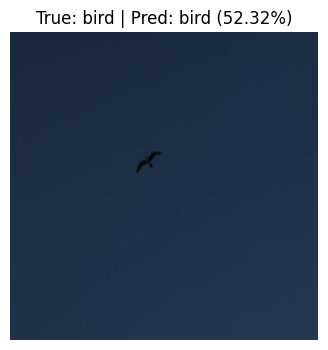

In [36]:
# Gather all test images from folders
image_exts = {".jpg", ".jpeg", ".png", ".bmp"}
test_split_dir = RAW_CLASS_DIR / "test"
print("Test split dir:", test_split_dir, "exists:", test_split_dir.exists())

def get_all_test_images():
    all_paths = []
    for cls_name in class_names:
        cls_dir = test_split_dir / cls_name
        if not cls_dir.exists():
            print(f"⚠️ Missing folder: {cls_dir}")
            continue
        for f in cls_dir.iterdir():
            if f.suffix.lower() in image_exts:
                all_paths.append((f, cls_name))
    return all_paths

test_images = get_all_test_images()
print(f"Total test images found (raw): {len(test_images)}")

if len(test_images) == 0:
    raise ValueError("❌ No test images found in raw classification_dataset/test.")

# pick random image
img_path, true_class_name = random.choice(test_images)
print("\nRandom test image path:", img_path)
print("True label (from folder):", true_class_name)

# open image
img = Image.open(img_path)

# predict
pred_label, pred_idx, conf, probs = predict_image_pil(img, model, preprocess_mode)

print(f"\nPredicted: {pred_label} (confidence: {conf:.4f})")
print(f"Probs (per class index): {probs}")

# show image with predicted and true labels
plt.figure(figsize=(4,4))
plt.imshow(img)
plt.axis("off")
plt.title(f"True: {true_class_name} | Pred: {pred_label} ({conf:.2%})")
plt.show()



Image: F:\Aerial_Object_Classification_Detection\notebooks\data\processed\test\bird\0a7e246b483ed57b_jpg.rf.446903614d856f120545c0fc350c2209.jpg
Predicted: drone  (confidence: 0.5116)
Class probabilities:
  0 (bird): 0.4884
  1 (drone): 0.5116


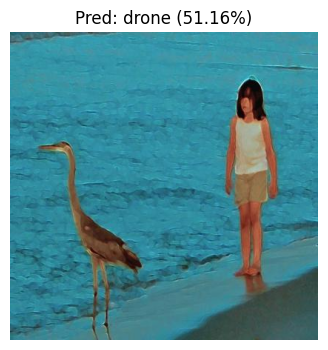

In [33]:
def predict_image_from_path(image_path, model, preprocess_mode: str):
    """
    High-level helper: given path, open image and run prediction.
    """
    image_path = Path(image_path)
    if not image_path.exists():
        print("❌ Image path does not exist:", image_path)
        return None
    
    img = Image.open(image_path)
    pred_label, pred_idx, conf, probs = predict_image_pil(img, model, preprocess_mode)
    
    print(f"\nImage: {image_path}")
    print(f"Predicted: {pred_label}  (confidence: {conf:.4f})")
    print("Class probabilities:")
    for idx, p in enumerate(probs):
        name = idx_to_name.get(idx, str(idx))
        print(f"  {idx} ({name}): {p:.4f}")
    
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Pred: {pred_label} ({conf:.2%})")
    plt.show()
    
    return pred_label, conf, probs

# 👉 Change this to a real path on your system if you want to test
custom_img_path = r"F:\Aerial_Object_Classification_Detection\notebooks\data\processed\test\bird\0a7e246b483ed57b_jpg.rf.446903614d856f120545c0fc350c2209.jpg"

if Path(custom_img_path).exists():
    predict_image_from_path(custom_img_path, model, preprocess_mode)
else:
    print("⚠️ Custom image path does not exist:", custom_img_path)
    print("Update 'custom_img_path' with a valid image path if you want to test.")


In [34]:
# For eval, we might need to apply preprocessing if model does NOT have internal rescaling
def preprocess_tensor_batch(x, mode: str):
    x = tf.cast(x, tf.float32)
    if mode == "raw_0_255":
        # input already [0,255], model has internal Rescaling(1/255)
        return x
    elif mode == "0_1":
        return x / 255.0
    elif mode == "minus1_1":
        return (x / 255.0) * 2.0 - 1.0
    else:
        raise ValueError(f"Unknown preprocess_mode: {mode}")

if preprocess_mode == "raw_0_255":
    eval_ds = test_ds
else:
    eval_ds = test_ds.map(lambda imgs, labels: (preprocess_tensor_batch(imgs, preprocess_mode), labels))

# Quick accuracy using model.evaluate
test_loss, test_acc = model.evaluate(eval_ds, verbose=0)
print(f"✅ Test accuracy (dataset-based): {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")


✅ Test accuracy (dataset-based): 0.7767
Test loss: 0.4607


In [35]:
y_true = []
y_pred = []

for batch_imgs, batch_labels in eval_ds:
    preds = model.predict(batch_imgs, verbose=0)
    preds_idx = np.argmax(preds, axis=1)
    y_true.extend(batch_labels.numpy().tolist())
    y_pred.extend(preds_idx.tolist())

acc = accuracy_score(y_true, y_pred)
print(f"\n✅ Test accuracy (manual): {acc:.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))



✅ Test accuracy (manual): 0.7767

Classification Report:
              precision    recall  f1-score   support

        bird       0.87      0.71      0.78       121
       drone       0.70      0.86      0.77        94

    accuracy                           0.78       215
   macro avg       0.78      0.79      0.78       215
weighted avg       0.79      0.78      0.78       215

